In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal, fft
from IPython.display import Audio

In [2]:
dir_files = './data/'

In [3]:
def cargar_audio(directorio, nombre, mono=False):
    # Cargar audio
    sr, data = io.wavfile.read(directorio+nombre)

    if mono:
        # Pasar de estéreo a mono
        if len(data.shape) > 1:
            data = (data[:,0].astype(float) + data[:,1].astype(float))/2

    # normalize maximum (absolute) amplitude
    data = data / np.max(abs(data)) * 0.9

    return sr, data

In [4]:
def cepstrum(s, N_f):
    N = len(s)
    N_ceps = 2*N

    S = fft.fft(s, n=N_ceps)

    magS = np.abs(S)

    S_hat = np.log(magS+1e-13)
    s_hat = fft.ifft(S_hat).real

    s_cepstrum = s_hat[:N]
    s_cepstrum[:N_f] = 0

    return s_cepstrum

In [5]:
def ST_cepstrum(s, L=2048, R=256, win='hann', N_f=80):
    """ compute the analysis phase of the phase vocoder, i.e. the STFT of the input audio signal
    
    Parameters
    ----------
    x : numpy array
        input audio signal (mono) as a numpy 1D array.
    L : int
        window length in samples.
    R : int
        hop size in samples.
    win : string
          window type as defined in scipy.signal.windows.    
        
    Returns
    -------
    X_stft : numpy array
             STFT of x as a numpy 2D array.
    omega_stft : numpy array
                 frequency values in radians.
    samps_stft : numpy array
                 time sample at the begining of each frame.

    """
    
    # length of the input signal
    M = s.size;      
    
    # number of points to compute the cepstrum
    N = L
    
    # analysis window
    window = signal.windows.get_window(win, L)
   
    # total number of analysis frames
    num_frames = int(np.floor((M - L) / R))

    # initialize stft
    s_hat = np.zeros((N, num_frames))
    
    # process each frame
    for ind in range(num_frames):

        # initial and ending points of the frame
        n_ini = int(ind * R)
        n_end = n_ini + L

        # signal frame
        s_w = window*s[n_ini:n_end]

        # save DFT of the signal frame
        s_hat[:, ind] = cepstrum(s_w, N_f)
        
    # frequency values in radians    
    quefrencys = np.arange(N)

    # # time sample at the center of each frame
    samps_ceps = np.arange(L/2, M-L/2+1, R)[:-1]
 
    return s_hat, samps_ceps, quefrencys

In [6]:
sr, s = cargar_audio(dir_files, 'Emily_Linge-vocals.wav', mono=True)
s = s[:20*sr]
Audio(s, rate=sr)

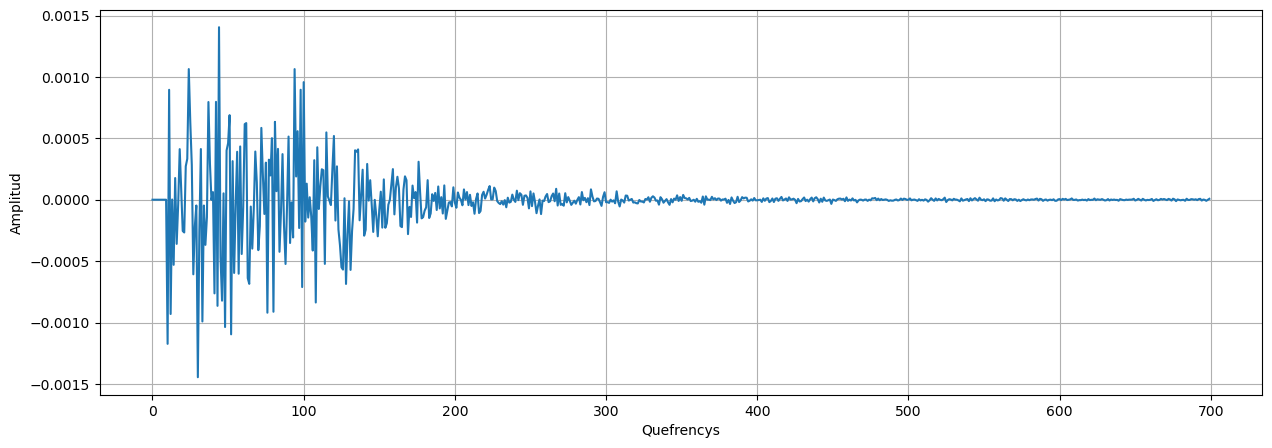

In [7]:
s_ceps = cepstrum(s[258000:258700], N_f=10)
plt.figure(figsize=(15,5))
plt.plot(s_ceps)
plt.xticks(np.arange(0,701,100))
plt.xlabel('Quefrencys')
plt.ylabel('Amplitud')
plt.grid()

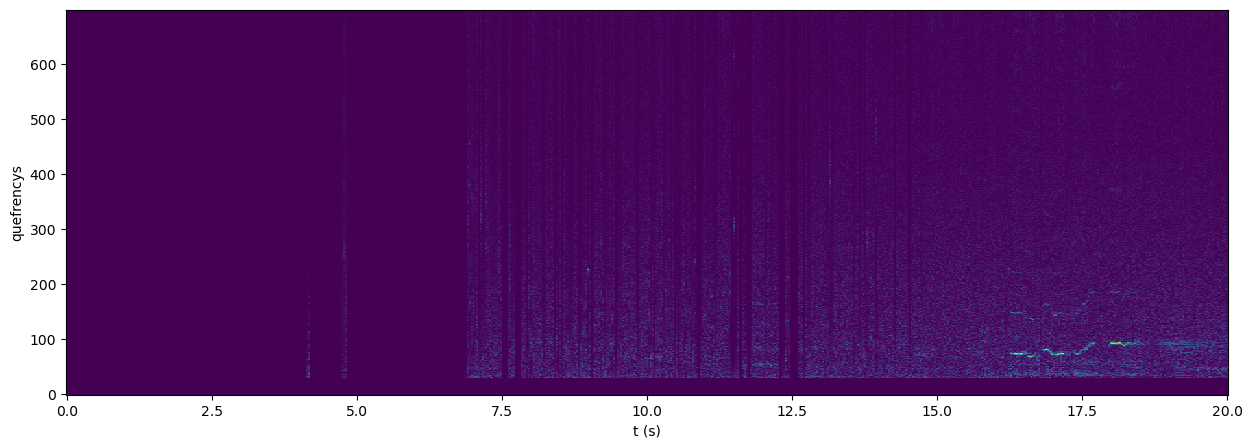

In [8]:
[s_hat, samps_ceps, quefrencys] = ST_cepstrum(s, L=700, R=700, N_f=30)
t = np.linspace(0, len(s)/sr, len(samps_ceps))
plt.figure(figsize=(15,5))
plt.pcolormesh(t, quefrencys, abs(s_hat), shading='auto')
plt.xlabel("t (s)")
plt.ylabel("quefrencys");

In [9]:
#Detección de Frecuencia Fundamental
pf_ind = np.zeros(s_hat.shape[1], dtype=int)

for i in range(s_hat.shape[1]):
    if np.max(s_hat[:,i])>0.2:
        pf_ind[i] = np.argmax(s_hat[:,i])
    else:
        pf_ind[i] = 0

pf = quefrencys[pf_ind]
ff = sr//pf

C:\Users\bener\AppData\Local\Temp\ipykernel_11560\3313278797.py:11: RuntimeWarning: divide by zero encountered in floor_divide
  ff = sr//pf


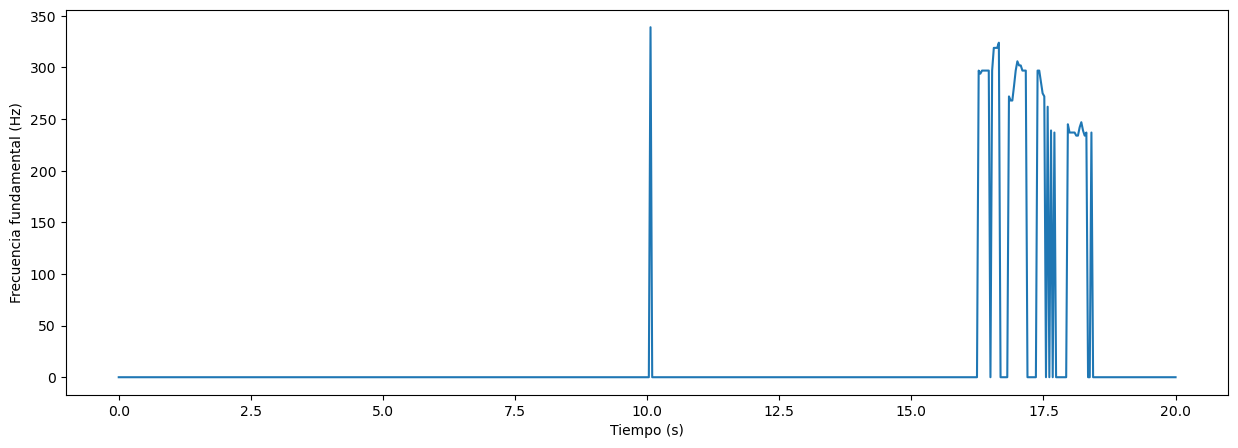

In [10]:
plt.figure(figsize=(15,5))
plt.plot(t, ff, 'tab:blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia fundamental (Hz)');